## Single Image Filtering with Neural Cellular Automata

Trains a pair of automata on the included "cube_and_sphere" images.

This code is based on the original [original notebook](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_pytorch.ipynb) of the ["μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata"](https://arxiv.org/abs/2111.13545) paper.


## Copying
```
Copyright 2021 Google LLC
Modifications copyright 2023 Pekka Väänänen

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

In [11]:
#@title imports, helpers 

import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import random
import requests
import numpy as np
import matplotlib.pylab as pl
from pathlib import Path

# !pip install -q --progress-bar off einops
from IPython.display import clear_output
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize
from functools import partial
import itertools

from rawloader import load_raw_data, parse_crop_xy_from_png_path
from style_crop_dataset import StyleCropDataset

print("Warning: setting manual random seed")
torch.manual_seed(0)
random.seed(123)

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def torch2pil(x):
  return np2pil(np.array(x.detach().permute(1, 2, 0).cpu()))

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a):
  if isinstance(a, torch.Tensor):
    a = np.array(a)
  display(np2pil(a))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


torch.set_default_tensor_type('torch.cuda.FloatTensor')

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)


In [12]:
#@title VGG16-based feature extraction 
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

## VGG Style Loss

# From which VGG-16 layers should we extract activations from.
# Changing this list also changes magnitudes of losses which is inconvenient.
style_layers = [1, 6, 11, 18]

def calc_styles_vgg(imgs):
  assert len(imgs.shape) == 4, "batch dim needed"
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      y = y - 1 # Novak2016 "shifted activation" to avoid sparse Gram matrices
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def vgg_style_loss_f_single(imgs, target_style):
  # imgs = [B x 3 x H x W]
  # target_style = list[list[tensor C x H x W]]
  xs = calc_styles_vgg(imgs) # list[tensor C x H x W]
  loss = 0.0
  for i, (x, y) in enumerate(zip(xs, target_style)):
    assert x.shape == y.shape
    weight = 2**(len(xs) - i) # Novak2016 Layer Weight Adjustment
    loss = loss + weight * (x-y).square().mean()
  return loss


def vgg_style_loss_f(imgs, target_style):
  assert isinstance(imgs, torch.Tensor)
  assert isinstance(target_style, list)
  batch_size = imgs.shape[0]
  assert len(imgs.shape) == 4
  assert batch_size == len(target_style)

  losses = torch.empty(batch_size)
  for b in range(batch_size):
    losses[b] = vgg_style_loss_f_single(imgs[b:(b+1)], target_style[b])
  
  return losses.mean()

# VGG Content Loss

def calc_activations_vgg(imgs):
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  activations = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)

    if i in style_layers:
      activations.append(x.clone())
  return activations

def vgg_content_loss_f_single(imgs, target_content):
  xs = calc_activations_vgg(imgs)
  loss = 0.0
  for i, (x, y) in enumerate(zip(xs, target_content)):
    weight = 2**i # Novak2016 weights for content loss
    loss = loss + weight * (x-y).square().mean()
  return loss
  

def vgg_content_loss_f(imgs, target_content):
  assert isinstance(imgs, torch.Tensor)
  assert isinstance(target_content, list)
  assert isinstance(target_content[0], list)
  batch_size = imgs.shape[0]
  assert len(imgs.shape) == 4
  assert imgs.shape[1] == 3, "images must be RGB"
  assert batch_size == len(target_content)

  losses = torch.empty(batch_size)
  for b in range(batch_size):
    losses[b] = vgg_content_loss_f_single(imgs[b:(b+1)], target_content[b])
  
  return losses.mean()


In [13]:
# μNCA by Alexander Mordvintsev and Eyvind Niklasson
#
# Modifications done to the original paper:
#
# - pre and postprocess filters have been added
# - start state is a feature image and not pure noise
# - trained against a combined content + style loss, not just style
# - automata are trained for a constant number of iterations
#   - we want to reproduce a single image so we can overfit
#   - their "pooling" of training samples is not used because we don't need robustness to
#      varying iteration counts
# - two 'CA' instances are put in a sequence.
#   - during training pictures are bilinearily upscaled between the two automata
# - trained with a more traditional style loss instead of their Optimal Transport loss
#   - OT loss was very slow and requires the "pykeinops" library not available on Windows
#   - style loss was modified to be "less sparse", see 'vgg_style_loss_f_single()' above

side = torch.tensor([[0.0, 0.0,0.0], [2.0,-2.0,0.0], [0.0, 0.0,0.0]]) 
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]) 
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# The original μNCA model supports many configurations but here only the "68 params" works.
filters = [lap]*2+[sobel_x]*1+[sobel_x.T]*1  # 68 params
# filters = [lap]*2+[sobel_x]*2+[sobel_x.T]*2 # 150 params
# filters = [lap]*4+[sobel_x]*2+[sobel_x.T]*2  # 264 params
# filters = [lap]*4+[sobel_x]*4+[sobel_x.T]*4  # 588 params

filters = torch.stack(filters)[:,None]
CHN = len(filters)

class CA(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.w = torch.nn.Parameter(torch.randn(CHN, 4*CHN+1, 1, 1)*1e-3)
    self.preproc = torch.nn.Conv2d(4, 4, kernel_size=1, bias=True)
    self.postproc = torch.nn.Conv2d(4, 4, kernel_size=1, bias=False)
    
    # Initialize 1x1 conv layers as no-ops
    with torch.no_grad():
      for layer in [self.preproc, self.postproc]:
        layer.weight[:] = torch.eye(4).reshape(4,4,1,1)
      self.preproc.bias[:] = 0
  
  def to_rgba(self, x):
    rgba = self.postproc(x) + 0.5
    return rgba

  def to_rgb(self, x):
    return self.to_rgba(x)[..., :3, :, :]

  def rule_parameters(self):
    return [self.w]

  def conv_parameters(self):
    return [self.preproc.weight] + [self.preproc.bias] + [self.postproc.weight]

  def forward(self, x, update_rate=1.0):
    y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'replicate')
    y = torch.nn.functional.conv2d(y, filters, groups=y.shape[1])
    y = torch.cat([x, y], 1)
    y = y = torch.cat([y, y.abs()], 1)
    #y = torch.cat([y.relu(), -(-y).relu()], 1)
    w, b = self.w[:,:-1], self.w[:,-1,0,0]
    y = torch.nn.functional.conv2d(y, w, b)
    if update_rate<1.0:
      y *= (torch.rand(*y.shape)+update_rate).floor()
    return x+y, y
    
ca = CA()
print('param count:', sum(p.numel() for p in ca.parameters()))
assert len(ca.rule_parameters()) + len(ca.conv_parameters()) == len(list(ca.parameters())), "should expose all parameters via getters"

param count: 104


Style image of shape (1024, 1024, 3)
Raw image of shape (512, 512, 4):
Target style image:


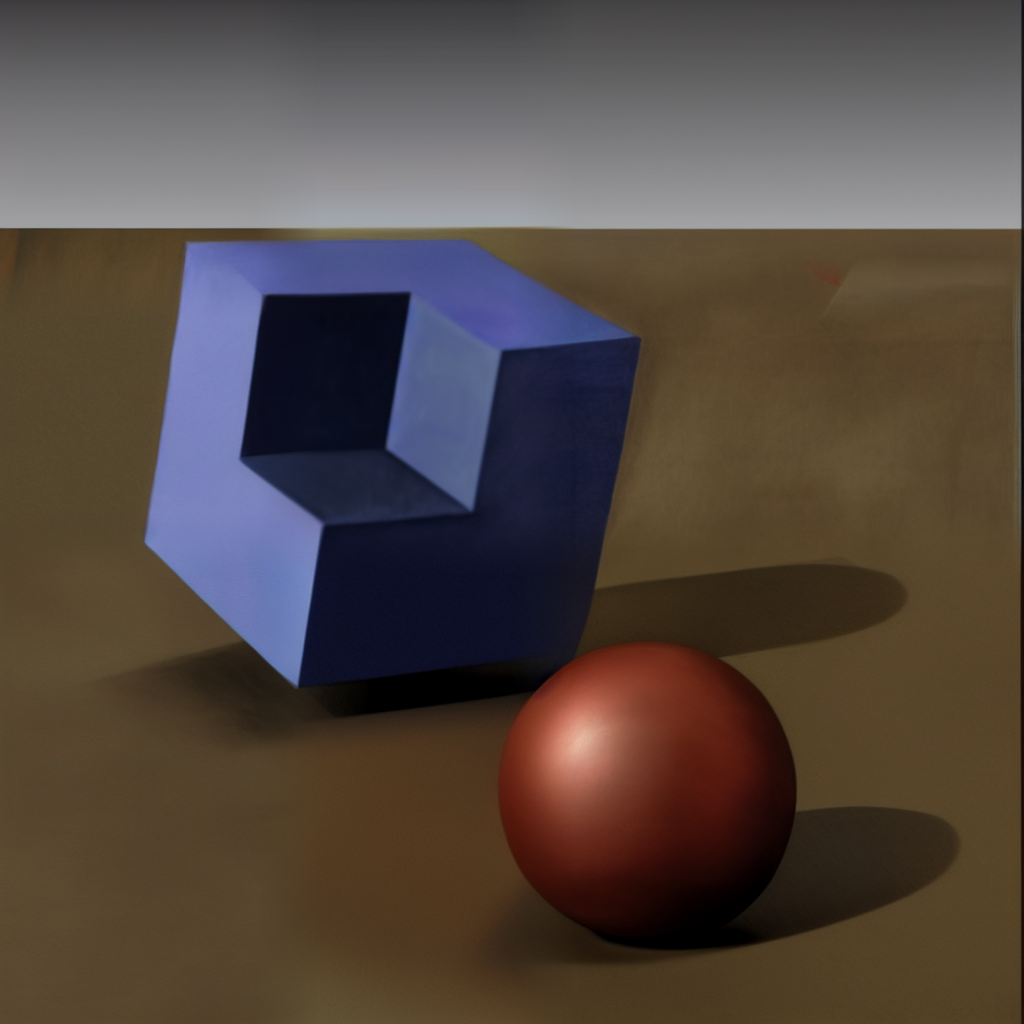

Input raw image:


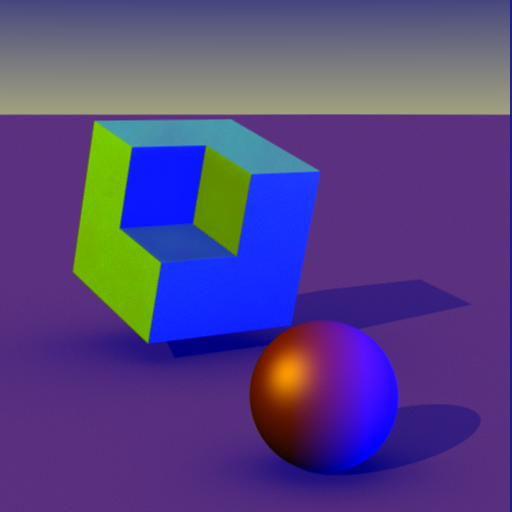

Dataset has 20 crops


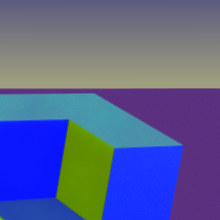

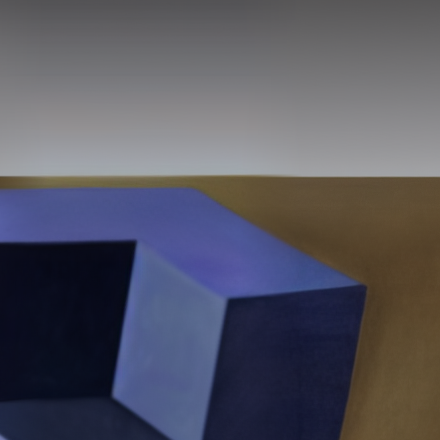

In [14]:
# Load training data

# Two ways to train: varying small windows around the image or almost the whole thing at once.
# Smaller crops are more flexible with VRAM usage but need a higher batch size.
# Larger crops produce a smoother image but with inaccurate colors. This is the default.
training_method = 'few larger crops'

# This default training confguration should fit in 8 GB of VRAM.
if training_method == 'many small crops':
  # Image crops need VGG-16 style activations that we precompute for training speed.
  num_precomputed_crops =  180
  # You can increase crop_size up to 255 if you have more than 8 GB of VRAM.
  crop_size = 96
  batch_size = 5
  # Multiplier for spatial "content" error, larger values make the image sharper but greyer.
  content_weight_factor = 1.0
elif training_method == 'few larger crops':
  num_precomputed_crops = 20
  crop_size = 220 # Decrease this if you run out of VRAM.
  # With a large crop size batch_size doesn't matter as much because only added noise
  # will be different across crops in a batch.
  batch_size = 2
  content_weight_factor = 1.5
else:
  raise RuntimeError("Invalid method " + training_method)

def data_to_paths(data_name):
  if data_name == 'cube_and_sphere':
    style_path = 'images/cube_and_sphere/painted_crop_230_16.png'
    content_path = 'images/cube_and_sphere/raw.rbnxd.f32.960.540.data'
  else:
    raise RuntimeError("Invalid name " + data_name)
  return style_path, content_path
  
  
def expand_to_rgba(x):
  assert len(x.shape) == 4
  assert x.shape[0] == 1

  if x.shape[1] == 3:
    x2 = torch.zeros([1, 4, *x.shape[2:4]], device=x.device)
    x2[0,:3,:,:] = x
    return x2
  else:
    return x

def load_dataset(style_path, content_path):
  with torch.no_grad():
    style_img = imread(style_path)

    if Path(content_path).suffix == '.data':
      raw_img = load_raw_data(content_path)
      # Crop coordinates expressed in the 960x540 image scale
      cropx, cropy = parse_crop_xy_from_png_path(style_path)
      cropw, croph = style_img.shape[1] // 2, style_img.shape[0] // 2
      raw_img = raw_img[cropy:(cropy+croph), cropx:(cropx+cropw)]
    else:
      raw_img = imread(content_path)

    print(f"Style image of shape {style_img.shape}")
    print(f"Raw image of shape {raw_img.shape}:")
    assert style_img.shape[0] == 2 * raw_img.shape[0]
    assert style_img.shape[1] == 2 * raw_img.shape[1]
    raw_tensor = expand_to_rgba(to_nchw(raw_img))
    style_tensor = expand_to_rgba(to_nchw(style_img))

    print("Target style image:")
    imshow(style_img)
    print("Input raw image:")
    imshow(raw_img[...,:3]+0.5)

    dataset = StyleCropDataset(raw_tensor[0], style_tensor[0], calc_styles_vgg, calc_activations_vgg,
                              num_crops=num_precomputed_crops, crop_size=crop_size)
    print(f"Dataset has {len(dataset)} crops")
    assert raw_tensor.device.type == 'cuda', "images should be on GPU by now"

  return dataset, raw_tensor, style_tensor

dataset, raw_tensor, style_tensor = load_dataset(*data_to_paths('cube_and_sphere'))

# Show some crops
for images in dataset[0:1]:
  display(torch2pil(images['input'][:3,...]+0.5))
  display(torch2pil(images['target']))

def collate(batch):
  """A collate function that keeps lists as lists. This way style and content activations can be
  returned as expected. Those lists have tensors of varying shapes so they can't be represented as
  a tensor."""

  packed = {}

  for key, value in batch[0].items():
    if isinstance(value, list):
      packed[key] = [b[key] for b in batch]
    elif isinstance(value, torch.Tensor):
      packed[key] = torch.stack([b[key] for b in batch], 0)
    else:
      raise TypeError(f"Unknown type {type(batch[0])}")
  
  return packed

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=raw_tensor.device), collate_fn=collate)

In [15]:
#@title setup training
ca = CA() 
ca2 = CA() 

# This 'pipeline' list could've been its own torch.nn.Module instead.
# It's evaluated in 'evaluate()' and 'run_whole_pipeline()' functions below.
pipeline = [ca, ca2]

# Train pre and postprocess layers with a higher learning rate because their gradients appear to be very small.
# Not really sure about this.
opt = torch.optim.Adam([
  {'params': ca.rule_parameters() + ca2.rule_parameters()},
   {'params': ca.conv_parameters() + ca2.conv_parameters(), 'lr': 1e-2, 'weight_decay': 1e-3}],
   lr=1e-3)

# Drop learning rate after 3000 iters. Just eyeballed this and didn't verify it actually helps much.
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [3000, 8000], 0.5)
loss_log = []

imgsize=raw_tensor.shape[2]
assert raw_tensor.shape[2] == raw_tensor.shape[2], "square images are a must"

# !rm *.pt

In [16]:
torch.backends.cudnn.benchmark = True # 

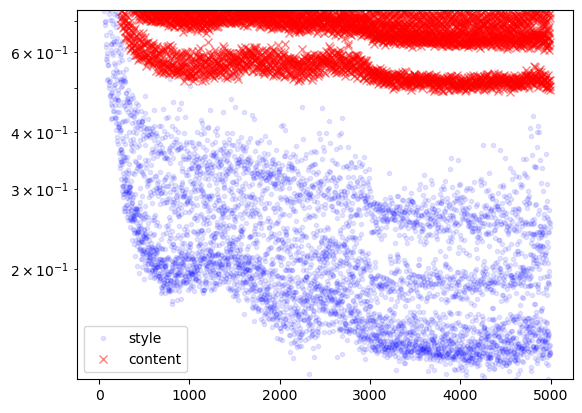

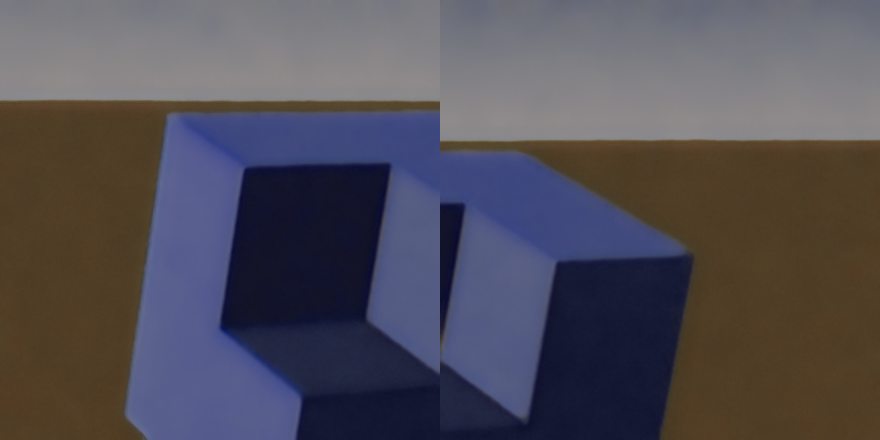

Saving checkpoint


In [17]:
#@title training loop {vertical-output: true}

load_best = False
max_iters = 5000
# How much noise are we adding to feature images (input) and upscaled intermediate results (middle).
input_noise_mag = 0.25 
middle_noise_mag = 0.25

# The number of steps each cellular automaton takes.
# The number 32 here works but probably isn't the best choice.
# If you make it too high, training will suffer because gradient magnitudes in the early steps
# become very small. See https://en.wikipedia.org/wiki/Vanishing_gradient_problem
# Longer number of steps also consume more VRAM because the model is trained with the "backprop through time" method.
ca_steps = 32

# We don't train for a number of "epochs" but a constant number of steps so we cycle the dataloader.
# This introduces a small problem: the training crops are always shown in the same order.
cycled_dataloader = itertools.cycle(loader)

def loss_f(rgb, x, iter, target_style, target_content):
  style = vgg_style_loss_f(rgb, [[b.detach() for b in a] for a in target_style])
  # Regularisation was a necessity for stable patterns in the original but in our case we could also do without and let
  # activations grow very large. But the results are more "interpretable" if values stay within clear bounds.
  reg = (x-x.clamp(-1.0, 1.0)).square().sum()
  content = 0.05 * content_weight_factor * vgg_content_loss_f(rgb, [[b.detach() for b in a] for a in target_content])

  # content = content * (style.detach() / content) # could force content and style loss magnitudes to match with this trick

  total_loss = style + 10 * reg + content
  return total_loss, style, content


def evaluate(pipeline, x, callback=None):
  """
  Runs the two automata in 'pipeline' starting from state 'x'.
  Returns x_middle, x_end.
  """
  for idx, automata in enumerate(pipeline):
    for _ in range(ca_steps):
      x, dx = automata(x)
      if x.requires_grad:
        # I don't understand why we also normalize the gradients below. Didn't touch this.
        x.register_hook(partial(F.normalize, dim=[1,2,3])) 
      if callback:
        callback(x.clone().detach(), idx, automata)
    if idx == 0:
      # x = automata.to_rgba(x)
      x = resize(x, (2*x.shape[2], 2*x.shape[3]))
      # After first phase and upscaling, apply the preprocessing filter.
      x = pipeline[1].preproc(x)
      # Add noise in the second latent space to make it more useful, maybe?
      x = x + middle_noise_mag * (torch.rand_like(x) - 0.5)
      x_middle = x.clone().detach()
  
  return x_middle, x
  
def run_whole_pipeline(pipeline, x, callback=None):
  """
  Preprocesses inputs, runs the models with upscaling inbetween, postprocesses outputs.

  Returns rgb (final result), x_middle, x_end
  """
  x = x + input_noise_mag * (torch.rand_like(x) - 0.5)
  x = pipeline[0].preproc(x)
  x_middle, x_end = evaluate(pipeline, x, callback=callback)
  return pipeline[1].to_rgb(x_end), x_middle, x_end

best_loss = np.inf
best_loss_step = 0

for i in range(max_iters):
  batch = next(cycled_dataloader)
  x = batch['input']

  torch.autograd.set_grad_enabled(True)
  # torch.autograd.set_detect_anomaly(True)

  # Freeze the second post proc layer
  pipeline[0].postproc.weight.requires_grad = False

  rgb, x_middle, x_end = run_whole_pipeline(pipeline, x)

  total_loss, style_loss, content_loss = loss_f(rgb, x_end, i, batch['target_style'], batch['target_content'])
  total_loss = total_loss
  total_loss.backward()
  with torch.no_grad():
    for automata in pipeline:
      for p in automata.rule_parameters():
        p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
      
    if ca2.postproc.weight.grad is not None:
      postproc2_grad_mag = ca2.postproc.weight.grad.norm()
    else:
      postproc2_grad_mag = torch.tensor(0.0)

    opt.step()
    opt.zero_grad()
    lr_sched.step()
    
    loss_log.append((style_loss.item(), content_loss.item()))

    if i%64==0:
      clear_output(True)
      losses = np.array(loss_log)

      min_loss = np.min(losses)
      pl.plot(losses[:,0], '.', alpha=0.1, color='blue', label='style')
      pl.plot(losses[:,1], 'x', alpha=0.5, color='red', label='content')
      pl.legend()
      if min_loss > 0.0:
        pl.yscale('log')
      pl.ylim(min_loss, losses[len(loss_log)//5].max())
      pl.show()
      imgs = rgb.permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
      pl.show()

      def show_weight(w):
        p = w[:,:,0,0]
        vis = torch.stack([(-p).relu(), p.relu(), 0.0*p], -1)
        vis *= 1.0/vis.max()
        imshow(zoom(vis))
        pl.show()
      
      show_weight(ca.w.cpu())
      show_weight(ca2.w.cpu())
      show_weight(torch.concat([ca.preproc.weight.cpu(), ca2.postproc.weight.cpu()], 2))

      if total_loss.item() < best_loss and (i - best_loss_step) > 100:
        print("Saving checkpoint")
        best_loss = total_loss
        best_loss_step = i
        torch.save(pipeline, f"ca_{i:05d}.pt")

    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' style:', style_loss.item(), 
        ' content:', content_loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')


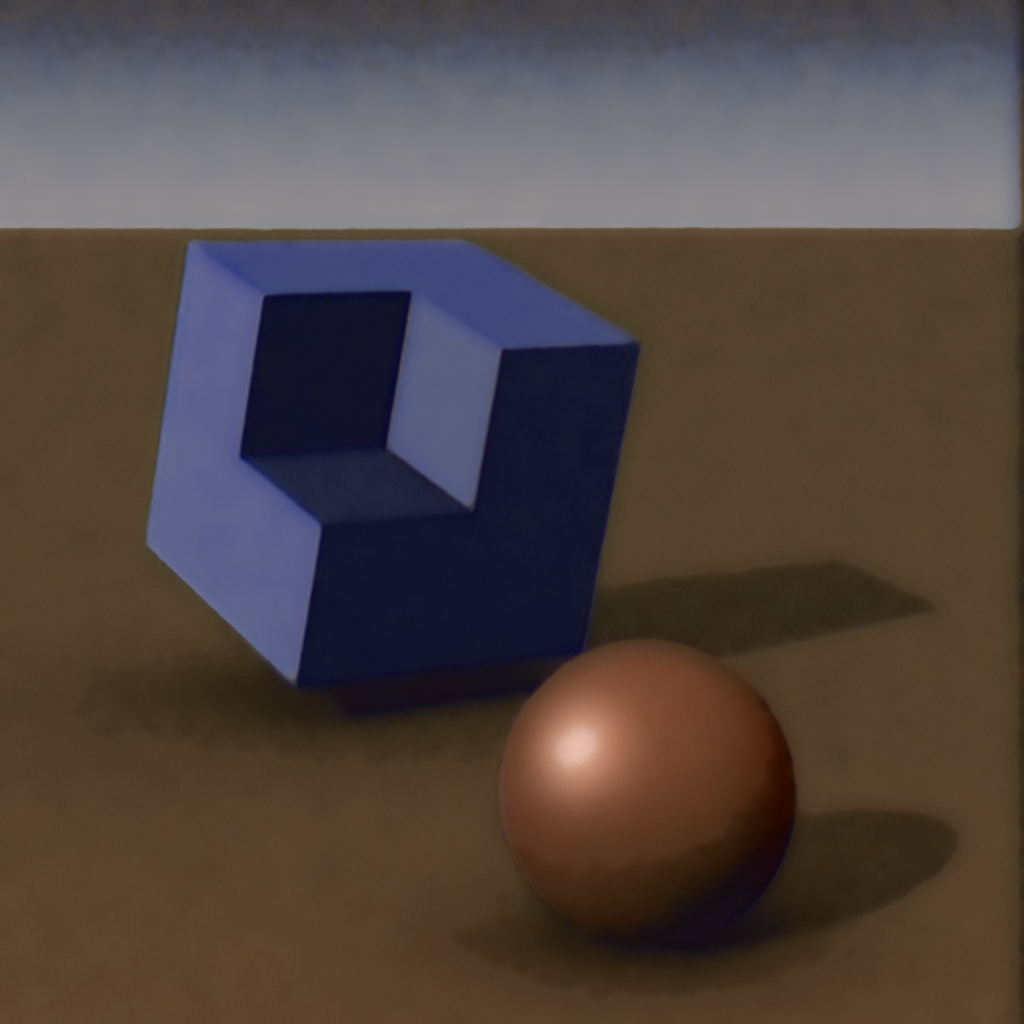

In [18]:
# Display result
with torch.no_grad():
  rgb, _, x_end = run_whole_pipeline(pipeline, raw_tensor)

display(torch2pil(rgb[0]))

In [19]:
# export model
assert len(filters) == 4, "export only works for two 4 channel models"

S = 1000.0
def quantize_params(w):
  return 1/S, (w*S).round()

def export_4filter_glsl_func(model, name="rule"):
  S = 1000.0
  scale, w = quantize_params(model.w[:,:,0,0])
  mat4 = 'mat4(%s)'%('%d,'*16)[:-1]
  ws = ["%.0e"%scale, 'vec4(%d,%d,%d,%d)'%tuple(w[:,-1])]+[mat4%tuple(P.ravel()) for P in w.T[:-1].reshape(4, 4, 4)]
  code = 'vec4 ' + name + '''(vec4 s, vec4 p) {
    return %s*(%s+
      %s*s+
      %s*p+
      %s*abs(s)+
      %s*abs(p));
  }'''%tuple(ws)
  return code

def export_mat4(m,quantize=False):
  if quantize:
    scale, w = quantize_params(m)
    cols = ['%d'%x.item() for x in w.T.ravel()]
    return f"{scale:.0e}*mat4({','.join(cols)});"
  else:
    cols = ['%.3f'%x.item() for x in m.T.ravel()]
    return f"mat4({','.join(cols)});"

def export_mat4x3(m,quantize=False):
  assert m.shape[0] == 3 and m.shape[1] == 4, "GLSL mat4x3 matrix has 3 rows and 4 columns"
  if quantize:
    scale, w = quantize_params(m)
    cols = ['%d'%x.item() for x in w.T.ravel()]
    return f"{scale:.0e}*mat4x3({','.join(cols)});"
  else:
    cols = ['%.3f'%x.item() for x in m.T.ravel()]
    return f"mat4x3({','.join(cols)});"

def export_vec4(bias):
  assert bias.shape[0] == 4
  # Quantizing to ints doesn't make sense here because the %.3 formatted floats are almost as short.
  # Compare:
  #
  #   vec3(-0.426,0.035,-0.475);
  #   1e-03*vec3(-426,35,-475);
  #
  # Plus ShaderMinifier will strip all leading zeros anyway.

  cols = ['%.3f'%x.item() for x in bias]
  return f"vec4({','.join(cols)});"

with torch.no_grad():
  model_name = "model"
  print("// update rules for draw.frag")
  print(export_4filter_glsl_func(pipeline[0], model_name + "1"))
  print()
  print(export_4filter_glsl_func(pipeline[1], model_name + "2"))
  print()

  print("// preprocessing for draw.frag")
  print(f"mat4 {model_name}_pre1_w = " + export_mat4(pipeline[0].preproc.weight[:,:,0,0]))
  print(f"vec4 {model_name}_pre1_bias = " + export_vec4(pipeline[0].preproc.bias))

  postw = pipeline[1].postproc.weight[:3,:,0,0]
  print(f"mat4x3 {model_name}_post2_w = " + export_mat4x3(postw))
  print()

  # The first postproc layer is frozen and just an identity matrix so it's ignored here.

  print("// postprocessing transform for present.frag")
  print(f"mat4 {model_name}_pre2_w = " + export_mat4(pipeline[1].preproc.weight[:,:,0,0]))
  print(f"vec4 {model_name}_pre2_bias = " + export_vec4(pipeline[1].preproc.bias))

// update rules for draw.frag
vec4 model1(vec4 s, vec4 p) {
    return 1e-03*(vec4(-18,31,92,69)+
      mat4(167,-30,34,-34,7,105,4,52,8,-25,13,-48,33,-6,65,-58)*s+
      mat4(81,-26,20,-23,-8,42,-5,6,1,-1,0,3,3,2,1,-5)*p+
      mat4(42,15,-31,39,6,0,46,-70,1,32,6,-5,4,-79,-10,33)*abs(s)+
      mat4(-50,0,-9,6,13,-16,3,-2,-7,4,-6,35,-4,-2,-3,2)*abs(p));
  }

vec4 model2(vec4 s, vec4 p) {
    return 1e-03*(vec4(-25,-10,-13,9)+
      mat4(-96,9,-5,-8,-39,-119,44,-35,30,-103,-111,107,42,29,-5,-211)*s+
      mat4(9,-5,0,5,15,14,0,-24,-17,-4,-1,8,-1,6,0,-8)*p+
      mat4(-27,-13,4,5,-16,45,36,-93,-9,-47,-121,-3,15,-1,8,20)*abs(s)+
      mat4(2,-4,-1,1,24,5,0,-1,-22,-1,10,3,-28,-16,0,26)*abs(p));
  }

// preprocessing for draw.frag
mat4 model_pre1_w = mat4(0.861,0.169,0.314,0.143,-0.087,1.532,0.635,-1.456,0.287,-0.497,-0.395,-1.214,0.239,-0.412,0.126,0.050);
vec4 model_pre1_bias = vec4(0.141,0.371,-0.047,0.008);
mat4x3 model_post2_w = mat4x3(0.751,0.346,0.222,0.051,1.207,0.161,0.329,0.724,1.

See [the original notebook](https://github.com/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_pytorch.ipynb) on how to export a 588 parameter model to ShaderToy.

In [20]:
# Export a progress video

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


with VideoWriter('processing.mp4', fps=10.0) as vid, torch.no_grad():
    x0 = raw_tensor.clone()

    def writer(x, phase, ca):
        if phase == 0:
            x = pipeline[1].preproc(x)

        img = pipeline[1].to_rgb(x)[0].permute(1,2,0).cpu()
        img = np.clip(img, 0, 100)
        img = (img / (1+img)) * 1.3 # Tone map intermediate values because they can get very large
        if img.shape[0] < style_tensor.shape[2]:
            img = zoom(img,2)
        vid.add(img)

    first_frame = 0.5 + x0[0,:3].permute(1,2,0).cpu()
    first_frame = zoom(first_frame, 2)
    for i in range(10):
      vid.add(first_frame)

    rgb, _, _ = run_whole_pipeline(pipeline, x0, callback=writer)
    last_frame = rgb[0].permute(1,2,0).cpu()
    for i in range(10):
      vid.add(last_frame)


vid.show()